# Unicode
Unicode characters provide a nice way to cleanly present your code and match standard math notation.

A list of available characters can be found here: (https://docs.julialang.org/en/v1/manual/unicode-input/index.html)

All unicode characters begin with a backslash '\' followed by a string of characters. The unicode with appear after clicking the tab key. 

For example: \alpha 

In [1]:
α = 1.0

1.0

Additionally, it is possible to include a select set of emojis since they are also unicode. 

For example: \:rocket:

In [2]:
🚀 = 1.0

1.0

# ForwardDiff.jl

Automatic differentiation enables gradients, Jacobian, and Hessians can be computed exactly (to machine precision) rapidly instead of relying on slow approximations from finite differencing. 

In [3]:
using ForwardDiff

f(x) = x[1]^2 + x[2]

f (generic function with 1 method)

In [4]:
ForwardDiff.gradient(f,ones(2))

2-element Array{Float64,1}:
 2.0
 1.0

## Control
We are interested in controlling systems, which are generally defined by differential equations of the form: 

$\dot{x} = f(x,u,t)$ 

For example, Dubins car dynamics are show below:

In [5]:
# inplace version
function dubins_dynamics!(ẋ,x,u,t)
    ẋ[1] = u[1]*cos(x[3])
    ẋ[2] = u[1]*sin(x[3])
    ẋ[3] = u[2]
    ẋ
end

function dubins_dynamics(x,u,t)
    return [u[1]*cos(x[3]); 
            u[1]*sin(x[3]); 
            u[2]]
end


dubins_dynamics (generic function with 1 method)

ForwardDiff requires functions of a single variable. To get around this, we can build an augmented vector of our variables $z = [x \ u \ t]^T$ and wrap our dynamics functions.

In [6]:
n = 3 # number of states
m = 2 # number of controls

function dubins_dynamics!(ż,z)
    x = z[1:n]
    u = z[n+1:n+m]
    t = z[n+m+1]
    dubins_dynamics!(ż,x,u,t)
end

function dubins_dynamics(z)
    x = z[1:n]
    u = z[n+1:n+m]
    t = z[n+m+1]
    dubins_dynamics(x,u,t)
end

dubins_dynamics (generic function with 2 methods)

Note: there is virtually no over head in creating functions wrappers like this. Additionally, these functions have access to the state and control dimensions defined above even though they are not inputs to the functions

In [7]:
# Define states, controls, time
x = [1.; 2.; 3.]
u = [4.; 5.]
t = [1.]
z = zeros(n);

In [8]:
# Jacobian of inplace function
ForwardDiff.jacobian(dubins_dynamics!,z,[x;u;t])

3×6 Array{Float64,2}:
 -0.0  -0.0  -0.56448  -0.989992  -0.0  -0.0
  0.0   0.0  -3.95997   0.14112    0.0   0.0
  0.0   0.0   0.0       0.0        1.0   0.0

In [9]:
# Jacobian
ForwardDiff.jacobian(dubins_dynamics,[x;u;t])

3×6 Array{Float64,2}:
 -0.0  -0.0  -0.56448  -0.989992  -0.0  -0.0
  0.0   0.0  -3.95997   0.14112    0.0   0.0
  0.0   0.0   0.0       0.0        1.0   0.0

It's often more convenient to compute Jacobians using $x, u, t$ instead of an augmented vector. Once again, we can create a wrapper that has no overhead to create a function $J(x,u,t)$ instead of $J(z)$.

In [10]:
function dubins_jacobians(x,u,t)
    J = ForwardDiff.jacobian(dubins_dynamics,[x;u;t])
    return J[:,1:n], J[:,n+1:n+m] # return the state and control (A,B) Jacobians
end

dubins_jacobians (generic function with 1 method)

In [11]:
A, B = dubins_jacobians(x,u,t);

In [12]:
@show A

A = [-0.0 -0.0 -0.56448; 0.0 0.0 -3.95997; 0.0 0.0 0.0]


3×3 Array{Float64,2}:
 -0.0  -0.0  -0.56448
  0.0   0.0  -3.95997
  0.0   0.0   0.0    

In [13]:
@show B

B = [-0.989992 -0.0; 0.14112 0.0; 0.0 1.0]


3×2 Array{Float64,2}:
 -0.989992  -0.0
  0.14112    0.0
  0.0        1.0

There are a number of options in ForwardDiff for inplace operations that will decrease memory allocation and reduce computation time. The best thing you can do is preallocate and make every operation inplace.

Note: When using dynamics with ForwardDiff, care must be taken to either define the function inputs as the union of the ForwardDiff 'dual' type and Array/Matrix/etc or as shown above don't declare the input type.

# ODE
Julia has a complete package of numerical differential equation solvers. See DifferentialEquations.jl

In [14]:
using ODE

x0 = zeros(n) # initial state

function controller(t::Float64)
    #u = [v; ω]
    return [1.0; sin(t)]
end


function dubins(t,x)
    dubins_dynamics(x,controller(t),t)
end

dubins (generic function with 1 method)

In [15]:
t_sim, x_sim = ode45(dubins, x0, 0:0.01:5);

Notice that the output from ODE is an array of arrays. It's often more convenient for plotting and other operations to have trajectories in 2D array or matrix form

In [16]:
@show typeof(x_sim)

X = zeros(n,length(t_sim))

for i = 1:length(t_sim)
    X[:,i] = x_sim[i]
end

typeof(x_sim) = Array{Array{Float64,1},1}


# Plots

In [17]:
using Plots

Julia will plot matrices column wise, so if a state trajectory is stored in an array as $X = [x_1 \ x_2 \ ... \ x_n]$ where $x_i \in R^n$, we simply plot $X^T$

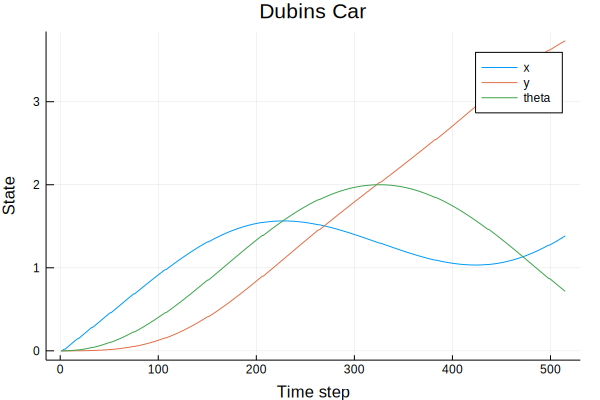

In [18]:
plot(X',title="Dubins Car",xlabel="Time step",ylabel="State",label=["x","y","theta"])

It is possible to overlay plots using the inplace operator $!$

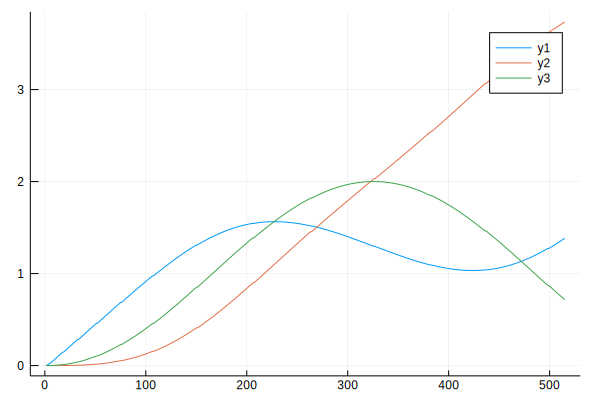

In [19]:
plot(X[1,:])
plot!(X[2,:])
plot!(X[3,:])

# LinearAlgebra.jl

Julia 1.0 no longer includes linear algebra functionality in the base workspace so it most be imported

In [20]:
using LinearAlgebra

In [21]:
Y = rand(3,3)

3×3 Array{Float64,2}:
 0.170641  0.740318  0.848104
 0.658796  0.870827  0.657388
 0.64836   0.340658  0.610461

## Eigen values

In [22]:
λ = eigvals(Y)
@show λ

λ = [1.84636, -0.45447, 0.260042]


3-element Array{Float64,1}:
  1.8463575612563847 
 -0.4544701020949622 
  0.26004242056374616

## Singular Value Decomposition

In [23]:
F = svd(Y)

@show F.S # singular values
@show F.Vt # input directions
@show F.U # output directions

F.S = [1.88541, 0.460615, 0.251259]
F.Vt = [-0.448407 -0.619319 -0.644496; -0.890987 0.367163 0.267083; -0.071226 -0.694 0.716444]
F.U = [-0.573674 0.751804 0.325098; -0.667448 -0.19901 -0.717571; -0.474775 -0.628638 0.615957]


3×3 Array{Float64,2}:
 -0.573674   0.751804   0.325098
 -0.667448  -0.19901   -0.717571
 -0.474775  -0.628638   0.615957

## Cholesky factorization

In [24]:
W = Y*Y'
W_sqrt = cholesky(W)

Cholesky{Float64,Array{Float64,2}}
U factor:
3×3 UpperTriangular{Float64,Array{Float64,2}}:
 1.13863  1.15458   0.773359
  ⋅       0.539858  0.4301  
  ⋅        ⋅        0.354981

# Arrays

In [25]:
a = rand(3,3)

3×3 Array{Float64,2}:
 0.498609  0.653558  0.981383
 0.846651  0.964494  0.124216
 0.960646  0.586026  0.338606

In [26]:
b = a

3×3 Array{Float64,2}:
 0.498609  0.653558  0.981383
 0.846651  0.964494  0.124216
 0.960646  0.586026  0.338606

In [27]:
a[:,1] = zeros(3)

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

In [28]:
@show a

a = [0.0 0.653558 0.981383; 0.0 0.964494 0.124216; 0.0 0.586026 0.338606]


3×3 Array{Float64,2}:
 0.0  0.653558  0.981383
 0.0  0.964494  0.124216
 0.0  0.586026  0.338606

In [29]:
@show b

b = [0.0 0.653558 0.981383; 0.0 0.964494 0.124216; 0.0 0.586026 0.338606]


3×3 Array{Float64,2}:
 0.0  0.653558  0.981383
 0.0  0.964494  0.124216
 0.0  0.586026  0.338606

## copy

In [30]:
c = copy(a)

3×3 Array{Float64,2}:
 0.0  0.653558  0.981383
 0.0  0.964494  0.124216
 0.0  0.586026  0.338606

In [31]:
a[:,2] = ones(3)

3-element Array{Float64,1}:
 1.0
 1.0
 1.0

In [32]:
@show a

a = [0.0 1.0 0.981383; 0.0 1.0 0.124216; 0.0 1.0 0.338606]


3×3 Array{Float64,2}:
 0.0  1.0  0.981383
 0.0  1.0  0.124216
 0.0  1.0  0.338606

In [33]:
@show c

c = [0.0 0.653558 0.981383; 0.0 0.964494 0.124216; 0.0 0.586026 0.338606]


3×3 Array{Float64,2}:
 0.0  0.653558  0.981383
 0.0  0.964494  0.124216
 0.0  0.586026  0.338606

## deepcopy

In [34]:
A = [rand(3) for i = 1:3]

3-element Array{Array{Float64,1},1}:
 [0.990228, 0.463193, 0.0905516]
 [0.437091, 0.868058, 0.328634] 
 [0.533283, 0.301649, 0.947444] 

In [35]:
B = A
C = deepcopy(A)

3-element Array{Array{Float64,1},1}:
 [0.990228, 0.463193, 0.0905516]
 [0.437091, 0.868058, 0.328634] 
 [0.533283, 0.301649, 0.947444] 

In [36]:
A[1] = 2.0*ones(3)

3-element Array{Float64,1}:
 2.0
 2.0
 2.0

In [37]:
@show B

B = Array{Float64,1}[[2.0, 2.0, 2.0], [0.437091, 0.868058, 0.328634], [0.533283, 0.301649, 0.947444]]


3-element Array{Array{Float64,1},1}:
 [2.0, 2.0, 2.0]               
 [0.437091, 0.868058, 0.328634]
 [0.533283, 0.301649, 0.947444]

In [38]:
@show C

C = Array{Float64,1}[[0.990228, 0.463193, 0.0905516], [0.437091, 0.868058, 0.328634], [0.533283, 0.301649, 0.947444]]


3-element Array{Array{Float64,1},1}:
 [0.990228, 0.463193, 0.0905516]
 [0.437091, 0.868058, 0.328634] 
 [0.533283, 0.301649, 0.947444] 

## Indexing

In [39]:
H = rand(3,3)

3×3 Array{Float64,2}:
 0.598566  0.310678  0.690864 
 0.772215  0.255205  0.0360947
 0.434848  0.849135  0.659494 

In [40]:
@show H[1,3]

H[1, 3] = 0.6908638864455754


0.6908638864455754

In [41]:
@show H[CartesianIndex{2}(1,3)]

H[CartesianIndex{2}(1, 3)] = 0.6908638864455754


0.6908638864455754

In [42]:
@show H[7]

H[7] = 0.6908638864455754


0.6908638864455754

In [43]:
for h in H
    println(h)
end

0.5985659208192682
0.7722151419511305
0.43484804458649085
0.3106784513812879
0.25520537846464264
0.8491347715875868
0.6908638864455754
0.036094737077893235
0.6594941934192238


In [44]:
for i in eachindex(H)
    println(i)
end

1
2
3
4
5
6
7
8
9


In [45]:
for i in eachindex(view(H,1:3,1:3))
    println(i)
end

CartesianIndex(1, 1)
CartesianIndex(2, 1)
CartesianIndex(3, 1)
CartesianIndex(1, 2)
CartesianIndex(2, 2)
CartesianIndex(3, 2)
CartesianIndex(1, 3)
CartesianIndex(2, 3)
CartesianIndex(3, 3)


When manipulating matrices, we often repeatedly operate on the same indices. We can pre-generate this indexing for faster compute. This is typically the fastested indexing operation. For example, if we want the bottom 2x2 block from H we assemble the linear indices:

In [46]:
idx = [5 8; 6 9]

2×2 Array{Int64,2}:
 5  8
 6  9

In [47]:
H[idx]

2×2 Array{Float64,2}:
 0.255205  0.0360947
 0.849135  0.659494 

## Assignment


In [48]:
D = rand(3,3)

3×3 Array{Float64,2}:
 0.914243  0.218751   0.70508   
 0.6067    0.882738   0.307459  
 0.719182  0.0292318  0.00076309

In [49]:
D .= a

3×3 Array{Float64,2}:
 0.0  1.0  0.981383
 0.0  1.0  0.124216
 0.0  1.0  0.338606

In [50]:
a[:,3] .= 2.0 # broadcasting

3-element view(::Array{Float64,2}, :, 3) with eltype Float64:
 2.0
 2.0
 2.0

In [51]:
@show a

a = [0.0 1.0 2.0; 0.0 1.0 2.0; 0.0 1.0 2.0]


3×3 Array{Float64,2}:
 0.0  1.0  2.0
 0.0  1.0  2.0
 0.0  1.0  2.0

In [52]:
@show D

D = [0.0 1.0 0.981383; 0.0 1.0 0.124216; 0.0 1.0 0.338606]


3×3 Array{Float64,2}:
 0.0  1.0  0.981383
 0.0  1.0  0.124216
 0.0  1.0  0.338606

## view

When working with trajectories it is often convenient to perform inplace operations on a preallocated matrix. However, inplace updates require using 'view' 

In [53]:
x = zeros(n)
X = zeros(n,5)

3×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [54]:
dubins_dynamics!(x,x0,controller(1.0),3.5)

3-element Array{Float64,1}:
 1.0               
 0.0               
 0.8414709848078965

In [55]:
dubins_dynamics!(X[:,1],x0,controller(1.0),3.5)

3-element Array{Float64,1}:
 1.0               
 0.0               
 0.8414709848078965

In [56]:
@show x

x = [1.0, 0.0, 0.841471]


3-element Array{Float64,1}:
 1.0               
 0.0               
 0.8414709848078965

In [57]:
@show X

X = [0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0]


3×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

Now using 'view':

In [58]:
dubins_dynamics!(view(X,:,1),x0,controller(1.0),3.5)

3-element view(::Array{Float64,2}, :, 1) with eltype Float64:
 1.0               
 0.0               
 0.8414709848078965

In [59]:
@show X

X = [1.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0; 0.841471 0.0 0.0 0.0 0.0]


3×5 Array{Float64,2}:
 1.0       0.0  0.0  0.0  0.0
 0.0       0.0  0.0  0.0  0.0
 0.841471  0.0  0.0  0.0  0.0

## Arrays of array

We found for our solver that it is computationally faster to work with trajectories that are store as an array of arrays. To construct this type we use list comprehension:

In [60]:
X1 = [zeros(n) for i = 1:5]

@show X1

X1 = Array{Float64,1}[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]


5-element Array{Array{Float64,1},1}:
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0]

In this case we do not need to use 'view' to perform inplace update:

In [61]:
dubins_dynamics!(X1[1],x0,controller(1.0),3.5)

3-element Array{Float64,1}:
 1.0               
 0.0               
 0.8414709848078965

In [62]:
@show X1

X1 = Array{Float64,1}[[1.0, 0.0, 0.841471], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]


5-element Array{Array{Float64,1},1}:
 [1.0, 0.0, 0.841471]
 [0.0, 0.0, 0.0]     
 [0.0, 0.0, 0.0]     
 [0.0, 0.0, 0.0]     
 [0.0, 0.0, 0.0]     

## Symbols

Symbols are defined using a ':' followed by characters. 

In [63]:
classification = :zoh

typeof(classification)

Symbol

In [64]:
if classification == :zoh
    println("Zero-order hold problem")
elseif classification == :foh
    println("First-order hold problem")
end

Zero-order hold problem


Single line if statements can help declutter your code, and make you look fancy. The format is:

(check this) ? (do this if true) : do this is false

In [65]:
classification == :zoh ? println("Zero-order hold problem") : nothing

Zero-order hold problem


In [66]:
classification == :foh ? println("Zero-order hold problem") : nothing

## Custom types

In [67]:
struct LQR_Objective
    Q::Matrix
    R::Matrix
    Qf::Matrix
end

In [68]:
Q = 1.0*Matrix(I,5,5)
R = 0.1*Matrix(I,2,2)
Qf = 100.0*Matrix(I,5,5)

objective = LQR_Objective(Q,R,Qf)

LQR_Objective([1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [0.1 0.0; 0.0 0.1], [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0])

In [69]:
@show typeof(objective)

typeof(objective) = LQR_Objective


LQR_Objective

In [70]:
function display_objective(Q::Matrix, R::Matrix, Qf::Matrix)
    println("LQR Objective:\n Q: $Q\n R: $R\n Qf: $Qf")
end

display_objective (generic function with 1 method)

In [74]:
function display_objective(obj::LQR_Objective)
    println("LQR Objective:\n Q: $(obj.Q)\n R: $(obj.R)\n Qf: $(obj.Qf)")
end

display_objective (generic function with 2 methods)

In [75]:
@show display_objective(Q,R,Qf)

LQR Objective:
 Q: [1.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 1.0]
 R: [0.1 0.0; 0.0 0.1]
 Qf: [100.0 0.0 0.0 0.0 0.0; 0.0 100.0 0.0 0.0 0.0; 0.0 0.0 100.0 0.0 0.0; 0.0 0.0 0.0 100.0 0.0; 0.0 0.0 0.0 0.0 100.0]
display_objective(Q, R, Qf) = nothing


In [76]:
@show display(objective)

LQR_Objective([1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0], [0.1 0.0; 0.0 0.1], [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0])

display(objective) = nothing
